In [1]:
# Copyright (c) 2023, ISCS, Wenjie Zhang.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from __future__ import absolute_import, division, print_function, unicode_literals

import argparse

import builtins
import datetime
import json
import sys
import time

import numpy as np
import torch

from dsmeasure2.core.dsm_device_mng   import DeviceManager
from dsmeasure2.core.dsm_operator_mng import OperatorManager

from dsmeasure2.core.dsm_tensor   import AbstractTensor
from dsmeasure2.core.dsm_device   import AbstractDeviceConfig, AbstractDevice
from dsmeasure2.core.dsm_operator import AbstractOperatorConfig, \
                                         AbstractOperator, \
                                         OperatorComputationalConfig, \
                                         OperatorNonComputationalConfig , \
                                         OperatorCustomConfig , \
                                         OpStaticComputational , \
                                         OpStaticNonComputational, \
                                         OpStaticDerivative

from dsmeasure2.device.device_cuda import DeviceCUDA, DeviceCUDAConfig
from dsmeasure2.device.device_pcie import DevicePCIE4, DevicePCIEConfig

from dsmeasure2.core.dsm_tensor_mng    import TensorManager
from dsmeasure2.graph.tensor_define    import ActivationTensor, WeightTensor, TensorState
from dsmeasure2.graph.operator_graph   import UnaryOperator, BinaryOperator, TernaryOperator, InitiateOperator
from dsmeasure2.graph.unary_operator   import make_linear, make_layernorm, make_dropout, make_gelu, make_softmax
from dsmeasure2.graph.binary_operator  import make_add, make_matmul
from dsmeasure2.graph.operator_attn    import make_attn_tp, AttentionTPCRParallel, AttentionTPCRParallelBackward
from dsmeasure2.graph.dsm2_transformer import make_ffn_gpt2, FeedForwardGPT2, FeedForwardGPT2Backward, \
                                              make_transformer_block, TransformerBlockGPT2, TransformerBlockGPT2Backward
from dsmeasure2.graph.gpt2_sequence    import make_gpt_2
from dsmeasure2.engine import CostEngine

from dsmeasure2.flatten.flatten import flatten, convert_graph_to_flatten_seq
from dsmeasure2.flatten.flatten_engine import FlattenEngine
from dsmeasure2.flatten.flatten_stream import FlattenStream
from dsmeasure2.flatten.flatten_offload import make_passive_offload
from dsmeasure2.flatten.flatten_operator import FlattenInitiate, FlattenOperator

In [2]:
gpt2 = make_gpt_2(
        compute_time_linear_qkv=490,
        compute_time_matmul_kq=214, 
        compute_time_sm=163,
        compute_time_attention_dropout=286,
        compute_time_matmul_v=191,
        compute_time_linear=146,
        compute_time_dropout_attn=140,

        compute_time_linear_qkv_backward=340,
        compute_time_matmul_kq_backward=531,
        compute_time_sm_backward=212,
        compute_time_attention_dropout_backward=248,
        compute_time_matmul_v_backward=360,
        compute_time_linear_backward=250,
        compute_time_dropout_attn_backward=155,

        compute_time_allreduce_attn=2200,

        compute_time_linear_1=512,
        compute_time_gelu=428,
        compute_time_linear_2=483,
        compute_time_dropout_ffn=75,
        
        compute_time_linear_1_backward=442,
        compute_time_gelu_backward=210,
        compute_time_linear_2_backward=100,
        compute_time_dropout_ffn_backward=102,

        compute_time_allreduce_ffn=2200,
        
        compute_time_layernorm_1=67,
        compute_time_layernorm_2=67,
        compute_time_residual_add_1=67,
        compute_time_residual_add_2=67,

        compute_time_layernorm_1_backward=236,
        compute_time_layernorm_2_backward=236,

        compute_time_loss_with_backward=20000,

        batch_size=8,
        seq_len=1024,
        hidden_size=1792,
        head_num=16,
        head_hidden_size=112,
        tensor_parallel=2,
        precision=2,

        transfomer_block_num=1
    )
for _op in gpt2:
        OperatorManager().register(_op)

In [4]:
DeviceManager().register(DeviceCUDAConfig(memory_max_capacity=40000, memory_limit_capacity=40000))
DeviceManager().register(DevicePCIEConfig())
# CostEngine().evaluation(10, [_op._config.op_uid for _op in gpt2])
seq2 = flatten([_op._config.op_uid for _op in gpt2], [0], False)
seq2 = convert_graph_to_flatten_seq([_op._config.op_uid for _op in gpt2], [0])
stream_0 = FlattenStream(seq2)

In [5]:
FlattenEngine().evaluation([stream_0], 10)
a = FlattenEngine()._cuda_mem_trace.copy()

<operator-106, init_fn>
<operator-107, layernorm_forward>
<operator-108, linear_qkv>
<operator-109, matmul_qk>
<operator-110, softmax_forward>
<operator-111, dropout_forward>
<operator-112, matmul_v>
<operator-113, linear_forward>
<operator-114, allreduce_forward>
<operator-115, output_dropout>
<operator-116, add_forward>
<operator-117, layernorm_forward>
<operator-118, linear_1_forward>
<operator-119, gelu_forward>
<operator-120, linear_2_forward>
<operator-121, allreduce_forward>
<operator-122, dropout_forward>
<operator-123, add_forward>
<operator-124, loss_fn>
<operator-125, dropout_backward>
<operator-126, linear_2_backward>
<operator-127, gelu_backward>
<operator-128, linear_1_backward>
<operator-129, allreduce_backward>
<operator-130, layernorm_backward>
<operator-131, backward_grad_accumulate_res1>
<operator-132, output_dropout_backward>
<operator-133, linear_backward>
<operator-134, matmul_v_backward>
<operator-135, dropout_backward>
<operator-136, softmax_backward>
<operator-

In [6]:
stream_offload_linear_qkv_148 = make_passive_offload(stream_0, 2, 107)
FlattenEngine().evaluation([stream_0, stream_offload_linear_qkv_148], 10)
b = FlattenEngine()._cuda_mem_trace.copy()

<operator-106, init_fn>
<operator-107, layernorm_forward>
<operator-108, linear_qkv>
<operator-145, linear_qkv_branch_offload>
<operator-109, matmul_qk>
<operator-142, linear_qkv_offload>
<operator-144, linear_qkv_offload_loadin_pause>
<operator-110, softmax_forward>
<operator-111, dropout_forward>
<operator-112, matmul_v>
<operator-113, linear_forward>
<operator-114, allreduce_forward>
<operator-115, output_dropout>
<operator-116, add_forward>
<operator-117, layernorm_forward>
<operator-118, linear_1_forward>
<operator-119, gelu_forward>
<operator-120, linear_2_forward>
<operator-121, allreduce_forward>
<operator-122, dropout_forward>
<operator-123, add_forward>
<operator-124, loss_fn>
<operator-125, dropout_backward>
<operator-126, linear_2_backward>
<operator-127, gelu_backward>
<operator-128, linear_1_backward>
<operator-129, allreduce_backward>
<operator-130, layernorm_backward>
<operator-131, backward_grad_accumulate_res1>
<operator-132, output_dropout_backward>
<operator-133, li

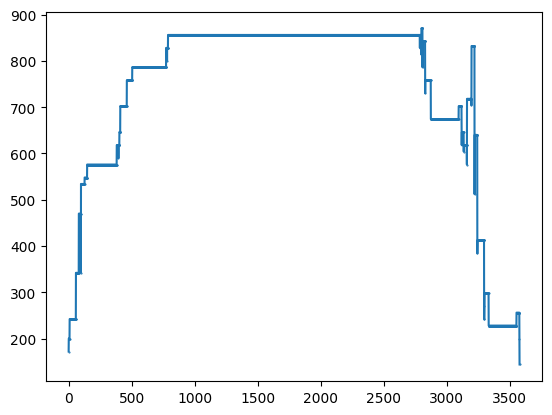

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(100,40))
plt.plot(list(range(len(FlattenEngine()._cuda_mem_trace))), FlattenEngine()._cuda_mem_trace, '.-', markersize=1)

In [7]:
# from dsmeasure2.flatten.flatten import flatten
# seq2 = flatten([_op._config.op_uid for _op in gpt2], [0], False)
# print(seq2)
# for _op in stream_0._flat_seq:
#         print([_op], 
#               _op._input if isinstance(_op, FlattenOperator) else None,
#               _op._output if isinstance(_op, FlattenOperator) else None)
# a = FlattenEngine()._cuda_mem_trace.copy()
print(a)
print(b)

[100, 128, 128, 128, 128, 128, 128, 128, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 298, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532,